# Creating dataset

# Creating classification model

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
print(keras.__version__)

2.4.3


In [2]:
DATASET_PATH = '../../datasets/Classification/Dataset - 7 dias'
CATEGORIES = ["Normal", "Anormal", "Morta"]

In [3]:
images_raw = open(os.path.join(DATASET_PATH, "7_days_images.pickle" ), "rb")
images = pickle.load(images_raw)

labels_raw = open(os.path.join(DATASET_PATH, "7_days_labels.pickle" ), "rb")
labels = pickle.load(labels_raw)

#reshape images
IMG_SIZE = 256

print(len(images))

1184


###### Train Test split

In [4]:
images = np.array(images)

from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, stratify=labels)

In [5]:
print("In training:")
for i in range(0,3):
    print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
print("In test:")
for i in range(0,3):
    print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')
    
# print("Proporção entre classes:")

In training:
Class 0: 78.99%
Class 1: 17.0%
Class 2: 4.01%
In test:
Class 0: 78.9%
Class 1: 16.88%
Class 2: 4.22%


#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [6]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [7]:
## Trying class weights
#it does not work withone hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

# from sklearn.utils import compute_sample_weight
# sample_weights = compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit


###### SMOTE

In [8]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

In [9]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
# train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [10]:
# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [11]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

##### One hot label encoding

In [12]:
import pandas as pd
train_labels = pd.get_dummies(train_labels)
train_labels = pd.DataFrame.to_numpy(train_labels)

test_labels_1d = test_labels

test_labels = pd.get_dummies(test_labels)
test_labels = pd.DataFrame.to_numpy(test_labels)

##### Normalizing training images

In [13]:
# train_images = tf.keras.utils.normalize(train_images, axis=0, order=2)

In [14]:
train_images[0].shape

(256, 256, 3)

### Creating the model


In [15]:
EPOCHS = 20
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 32
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

In [16]:
def create_model():
    base_model = keras.applications.Xception(
        weights='imagenet',  # Load weights pre-trained on ImageNet.
        input_shape=(IMG_SIZE, IMG_SIZE, 3),
        include_top=False
    )

    base_model.trainable = False

    inputs = keras.Input(shape=(IMG_SIZE,IMG_SIZE, 3))
    # We make sure that the base_model is running in inference mode here,
    # by passing `training=False`. This is important for fine-tuning, as you will
    # learn in a few paragraphs.
    x = base_model(inputs)
    # Convert features of shape `base_model.output_shape[1:]` to vectors
    x = keras.layers.GlobalAveragePooling2D()(x)
    # A Dense classifier 
    outputs = keras.layers.Dense(3, activation="sigmoid")(x)

    model = keras.Model(inputs, outputs)

    my_metrics = ["accuracy",
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall(),
               tf.keras.metrics.AUC(),
               tf.keras.metrics.TruePositives(),
               tf.keras.metrics.TrueNegatives(),
               tf.keras.metrics.FalsePositives(),
               tf.keras.metrics.FalseNegatives(),]

    opt = keras.optimizers.Adam(learning_rate=0.00001)
    # opt = tf.keras.optimizers.Adadelta(learning_rate=0.00001, rho=0.95, epsilon=1e-07, name='Adadelta')

    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)
    
    return model

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

metrics_index = 5

METRICDIR = '../metricas/classificacao/7_d/tests/'
MODELDIR = os.path.join(METRICDIR, "model")
CHECKPOINT_DIR = os.path.join(MODELDIR, "best_checkpoint")

my_callbacks = [
    ModelCheckpoint(CHECKPOINT_DIR, monitor=f"val_precision", verbose=1, save_best_only=True, mode='max', save_freq='epoch'),
    ReduceLROnPlateau(monitor=f'val_precision', factor=0.2, patience=2, min_lr=0.0000001, mode='max'),
]

In [39]:
from sklearn.model_selection import KFold

num_folds = 10

kfold = KFold(n_splits=num_folds, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in kfold.split(inputs, targets):

    model = create_model()

    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(inputs[train], targets[train],
              batch_size=batch_size,
              epochs=no_epochs,
              verbose=verbosity)

    # Generate generalization metrics
    scores = model.evaluate(inputs[test], targets[test], verbose=0)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])

    # Increase fold number
    fold_no = fold_no + 1

In [20]:
history = model.fit(train_images, train_labels, batch_size = BATCH_SIZE, epochs = EPOCHS, validation_split=TRAIN_TEST_SPLIT, callbacks=[my_callbacks])

Epoch 1/20
23/23 [==============================] - 60s 3s/step - loss: 1.2411 - accuracy: 0.8014 - precision: 0.6523 - recall: 0.7873 - auc: 0.8164 - true_positives: 559.0000 - true_negatives: 1122.0000 - false_positives: 298.0000 - false_negatives: 151.0000 - val_loss: 1.4192 - val_accuracy: 0.7637 - val_precision: 0.6529 - val_recall: 0.8017 - val_auc: 0.8005 - val_true_positives: 190.0000 - val_true_negatives: 373.0000 - val_false_positives: 101.0000 - val_false_negatives: 47.0000

Epoch 00001: val_precision improved from -inf to 0.65292, saving model to ../metricas/classificacao/7_d/tests/model/best_checkpoint
INFO:tensorflow:Assets written to: ../metricas/classificacao/7_d/tests/model/best_checkpoint/assets
Epoch 2/20
23/23 [==============================] - 58s 3s/step - loss: 1.1017 - accuracy: 0.8014 - precision: 0.6561 - recall: 0.7873 - auc: 0.8176 - true_positives: 559.0000 - true_negatives: 1127.0000 - false_positives: 293.0000 - false_negatives: 151.0000 - val_loss: 1.278

23/23 [==============================] - 59s 3s/step - loss: 0.8875 - accuracy: 0.8085 - precision: 0.6611 - recall: 0.7831 - auc: 0.8210 - true_positives: 556.0000 - true_negatives: 1135.0000 - false_positives: 285.0000 - false_negatives: 154.0000 - val_loss: 1.1249 - val_accuracy: 0.7637 - val_precision: 0.6562 - val_recall: 0.7975 - val_auc: 0.8070 - val_true_positives: 189.0000 - val_true_negatives: 375.0000 - val_false_positives: 99.0000 - val_false_negatives: 48.0000

Epoch 00015: val_precision did not improve from 0.65625
Epoch 16/20
23/23 [==============================] - 61s 3s/step - loss: 0.8868 - accuracy: 0.8085 - precision: 0.6611 - recall: 0.7831 - auc: 0.8210 - true_positives: 556.0000 - true_negatives: 1135.0000 - false_positives: 285.0000 - false_negatives: 154.0000 - val_loss: 1.1241 - val_accuracy: 0.7637 - val_precision: 0.6562 - val_recall: 0.7975 - val_auc: 0.8070 - val_true_positives: 189.0000 - val_true_negatives: 375.0000 - val_false_positives: 99.0000 - val_

##### Loading the best model for testing

In [21]:
model = keras.models.load_model(CHECKPOINT_DIR)

##### Testing the model

In [22]:
test_labels_1d = []
for label in test_labels:
    if (label == [1, 0, 0]).all():
        test_labels_1d.append(0)
    elif (label == [0, 1, 0]).all():
        test_labels_1d.append(1)
    else:
        test_labels_1d.append(2)

In [23]:
prediction = model.predict(test_images, batch_size=1)

prediction = tf.argmax(prediction, axis=-1)

In [24]:
import numpy as np
import matplotlib
import seaborn as sns



def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

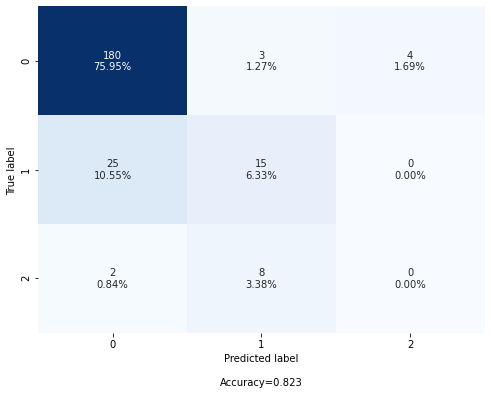

In [26]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics

cm = metrics.confusion_matrix(test_labels_1d, prediction)

make_confusion_matrix(cm, figsize=(8,6), cbar=False)

In [27]:
print(metrics.classification_report(test_labels_1d, prediction, digits=3))

              precision    recall  f1-score   support

           0      0.870     0.963     0.914       187
           1      0.577     0.375     0.455        40
           2      0.000     0.000     0.000        10

    accuracy                          0.823       237
   macro avg      0.482     0.446     0.456       237
weighted avg      0.783     0.823     0.798       237



#### Visualizing model data

In [28]:
import matplotlib.pyplot as plt

In [36]:
NUM_METRICS = len(my_metrics) + 1

SAVE = False

def plot_metric(metric_name, chart_name):
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if SAVE and not os.path.exists(METRICDIR):
        os.mkdir(METRICDIR)
    if SAVE:
        plt.savefig(os.path.join(METRICDIR, metric_name))
    plt.show()


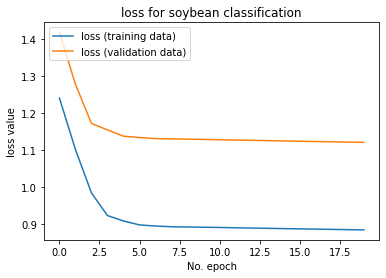

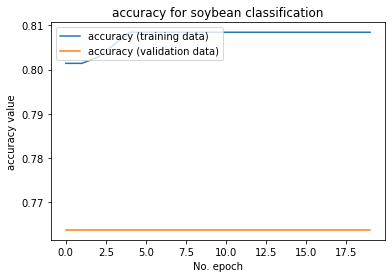

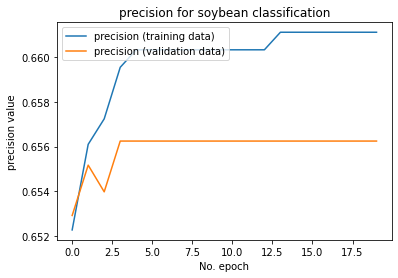

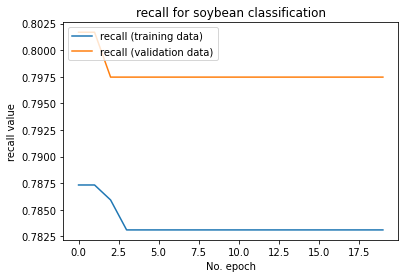

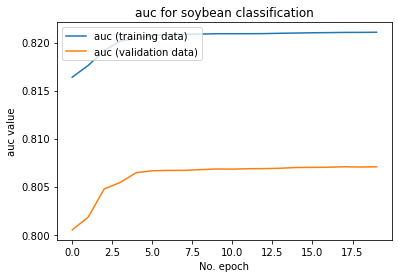

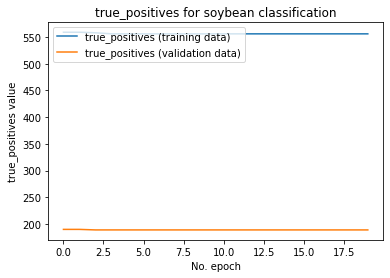

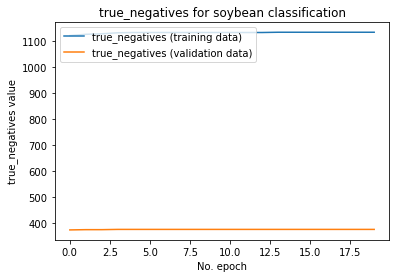

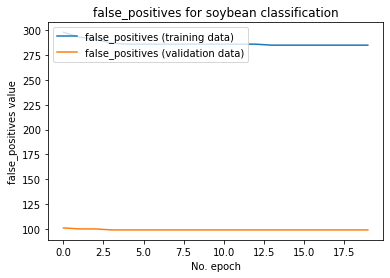

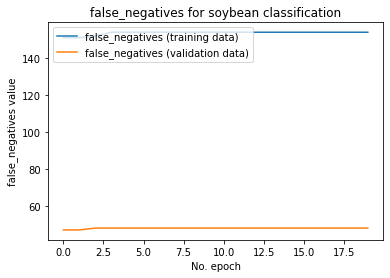

In [37]:
for metric in list(history.history.keys())[:NUM_METRICS]:
    plot_metric(metric, metric + " for soybean classification")
